In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# import data 
data = pd.read_csv("Train.csv")
data.head()

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,ID_ENTGC7,1/1/19,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.0
1,ID_8JCCXC,1/1/19,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.0
2,ID_V3136Z,1/1/19,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.0
3,ID_KRVZDJ,1/1/19,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.0
4,ID_PR351A,1/1/19,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.0


In [4]:
data['Date'] = pd.to_datetime(data['Date'], errors='coerce', dayfirst=True)

/var/folders/f4/4mwvrr4x2dg6l94x0rks7ypr0000gn/T/ipykernel_91744/3916194540.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce', dayfirst=True)


In [6]:
import numpy as np
import seaborn as sns

from scipy.interpolate import (
    CubicHermiteSpline,
    lagrange,
    BarycentricInterpolator,
    interp1d,
    UnivariateSpline,
    splrep,
    splev,
    Rbf,
    CubicSpline,
    BSpline,
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [6]:
print("\nMissing values in each column:")
print(data.isnull().sum())


Missing values in each column:
ID_Zindi                  0
Date                      0
ID                        0
LAT                       0
LON                       0
Precipitation             0
LST                   39786
AAI                   12875
CloudFraction         12875
NO2_strat             12875
NO2_total             12875
NO2_trop              35473
TropopausePressure    12875
GT_NO2                 4533
dtype: int64


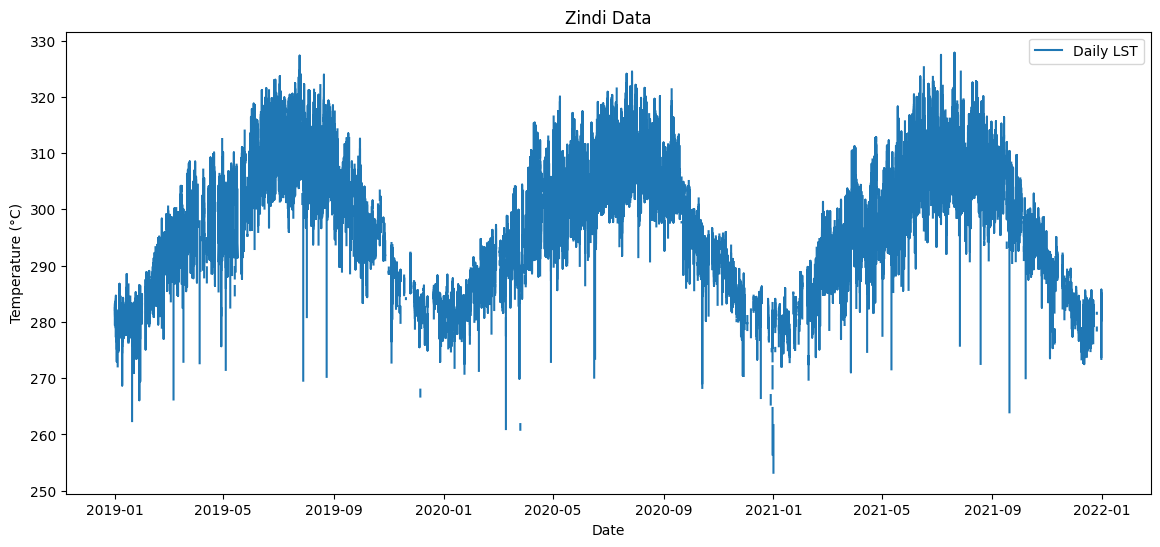

In [7]:
plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['LST'], label='Daily LST')
plt.title('Zindi Data')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

In [8]:
# reproduce the data 
'''
Index of df should maintain sequential time 
Normalization help in convergence of interpolation method 
Rate of change using derivative estimation -- help in interpolation
'''

'\nIndex of df should maintain sequential time \nNormalization help in convergence of interpolation method \nRate of change using derivative estimation -- help in interpolation\n'

In [44]:
df = data[['Date', 'LST', 'GT_NO2']]
df.head(10)

,Date,LST,GT_NO2
0,2019-01-01,NaN,31.0
1,2019-01-01,NaN,42.0
2,2019-01-01,NaN,31.0
3,2019-01-01,NaN,30.0
4,2019-01-01,NaN,58.0
5,2019-01-01,278.38,26.0
6,2019-01-01,NaN,38.0
7,2019-01-01,NaN,34.0
8,2019-01-01,NaN,41.0
9,2019-01-01,NaN,35.0


In [45]:
# reset index 
df.reset_index(drop = True, inplace = True)

# normalize 
scaler = MinMaxScaler()
df['LST_scaled'] = scaler.fit_transform(df[['LST']])
df['LST_scaled_bff'] = scaler.fit_transform(df[['LST']])

# get derivative 
df['Derivative_LST'] = df['LST_scaled'].diff() / 1 # assuming data is daily 

# handle NAN values 
df.loc[df.index[0], 'Derivative'] = df['LST_scaled'].iloc[1] - df['LST_scaled'].iloc[0]
df.loc[df.index[-1], 'Derivative'] = df['LST_scaled'].iloc[-1] - df['LST_scaled'].iloc[-2]

In [46]:
df.head(10)

,Date,LST,GT_NO2,LST_scaled,LST_scaled_bff,Derivative_LST,Derivative
0,2019-01-01,NaN,31.0,NaN,NaN,NaN,NaN
1,2019-01-01,NaN,42.0,NaN,NaN,NaN,NaN
2,2019-01-01,NaN,31.0,NaN,NaN,NaN,NaN
3,2019-01-01,NaN,30.0,NaN,NaN,NaN,NaN
4,2019-01-01,NaN,58.0,NaN,NaN,NaN,NaN
5,2019-01-01,278.38,26.0,0.337353,0.337353,NaN,NaN
6,2019-01-01,NaN,38.0,NaN,NaN,NaN,NaN
7,2019-01-01,NaN,34.0,NaN,NaN,NaN,NaN
8,2019-01-01,NaN,41.0,NaN,NaN,NaN,NaN
9,2019-01-01,NaN,35.0,NaN,NaN,NaN,NaN


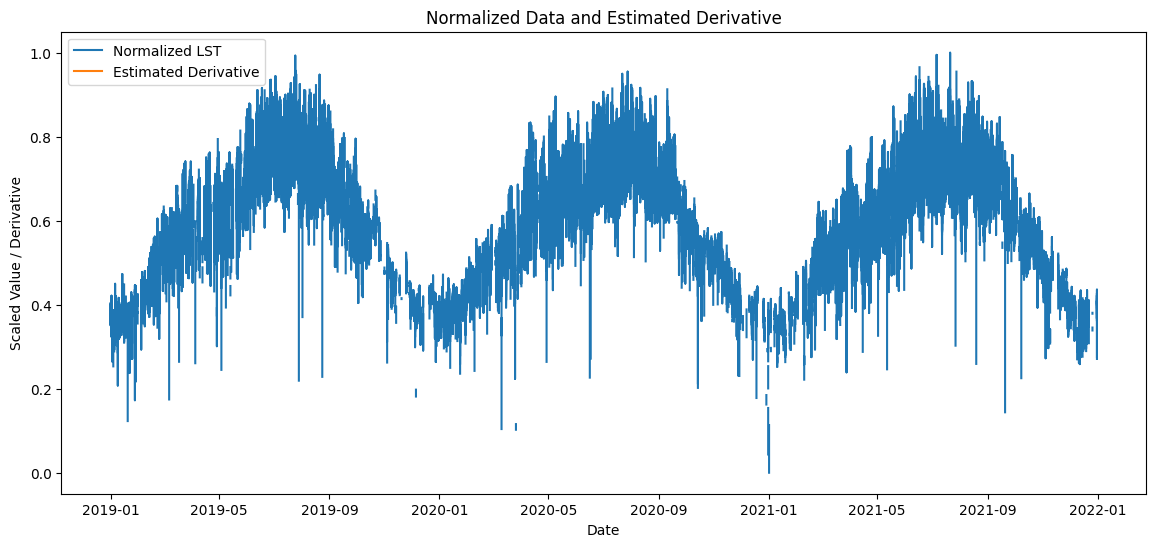

In [47]:
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['LST_scaled'], label='Normalized LST')
plt.plot(df['Date'], df['Derivative'], label='Estimated Derivative')
plt.title('Normalized Data and Estimated Derivative')
plt.xlabel('Date')
plt.ylabel('Scaled Value / Derivative')
plt.legend()
plt.show()

In [48]:
from scipy.interpolate import CubicSpline

# Mask to identify non-missing (finite) values
mask_finite = np.isfinite(df['LST_scaled'].values)

# Separate known (non-missing) indices and values
known_indices = df.index.values[mask_finite]
known_values = df['LST_scaled'].values[mask_finite]

# Indices where the values are missing
missing_indices = df.index.values[~mask_finite]

In [49]:
# Fit the spline to known data
cubic_spline = CubicSpline(known_indices, known_values)

In [50]:
df.loc[~mask_finite, 'LST_scaled'] = cubic_spline(missing_indices)

In [51]:
df.head(10)

,Date,LST,GT_NO2,LST_scaled,LST_scaled_bff,Derivative_LST,Derivative
0,2019-01-01,NaN,31.0,0.751059,NaN,NaN,NaN
1,2019-01-01,NaN,42.0,0.630035,NaN,NaN,NaN
2,2019-01-01,NaN,31.0,0.529771,NaN,NaN,NaN
3,2019-01-01,NaN,30.0,0.448649,NaN,NaN,NaN
4,2019-01-01,NaN,58.0,0.385049,NaN,NaN,NaN
5,2019-01-01,278.38,26.0,0.337353,0.337353,NaN,NaN
6,2019-01-01,NaN,38.0,0.303941,NaN,NaN,NaN
7,2019-01-01,NaN,34.0,0.283194,NaN,NaN,NaN
8,2019-01-01,NaN,41.0,0.273494,NaN,NaN,NaN
9,2019-01-01,NaN,35.0,0.273221,NaN,NaN,NaN


In [52]:
df['LST_scaled_bff'].fillna(method='ffill', inplace=True)

In [53]:
df['LST_scaled_bff'].fillna(method='bfill', inplace=True)

In [54]:
df.head(10)

,Date,LST,GT_NO2,LST_scaled,LST_scaled_bff,Derivative_LST,Derivative
0,2019-01-01,NaN,31.0,0.751059,0.337353,NaN,NaN
1,2019-01-01,NaN,42.0,0.630035,0.337353,NaN,NaN
2,2019-01-01,NaN,31.0,0.529771,0.337353,NaN,NaN
3,2019-01-01,NaN,30.0,0.448649,0.337353,NaN,NaN
4,2019-01-01,NaN,58.0,0.385049,0.337353,NaN,NaN
5,2019-01-01,278.38,26.0,0.337353,0.337353,NaN,NaN
6,2019-01-01,NaN,38.0,0.303941,0.337353,NaN,NaN
7,2019-01-01,NaN,34.0,0.283194,0.337353,NaN,NaN
8,2019-01-01,NaN,41.0,0.273494,0.337353,NaN,NaN
9,2019-01-01,NaN,35.0,0.273221,0.337353,NaN,NaN


In [57]:
test_df = df[['Date', 'GT_NO2', 'LST_scaled', 'LST_scaled_bff']]

In [58]:
test_df

,Date,GT_NO2,LST_scaled,LST_scaled_bff
0,2019-01-01,31.000,0.751059,0.337353
1,2019-01-01,42.000,0.630035,0.337353
2,2019-01-01,31.000,0.529771,0.337353
3,2019-01-01,30.000,0.448649,0.337353
4,2019-01-01,58.000,0.385049,0.337353
...,...,...,...,...
86579,2021-12-31,39.750,0.440411,0.407824
86580,2021-12-31,30.125,0.450341,0.407824
86581,2021-12-31,28.325,0.425777,0.425777
86582,2021-12-31,21.250,0.354884,0.425777


In [60]:
test_df.to_csv('interpolation_method.csv')

In [59]:
# Define split index (80% train, 20% test)
split_index = int(0.8 * len(test_df))
train_df = test_df.iloc[:split_index].copy()
val_df = test_df.iloc[split_index:].copy()

print(f"\nTraining data points: {train_df.shape[0]}")
print(f"Testing data points: {val_df.shape[0]}")


Training data points: 69267
Testing data points: 17317


## All data

In [4]:
data = pd.read_csv("Train.csv")
df = data[['Date', 'LST', 'GT_NO2']]
df.head()


,Date,LST,GT_NO2
0,1/1/19,NaN,31.0
1,1/1/19,NaN,42.0
2,1/1/19,NaN,31.0
3,1/1/19,NaN,30.0
4,1/1/19,NaN,58.0


In [7]:
scaler = MinMaxScaler()
df['LST_scaled'] = scaler.fit_transform(df[['LST']])

In [8]:
df.head(10)

,Date,LST,GT_NO2,LST_scaled
0,1/1/19,NaN,31.0,NaN
1,1/1/19,NaN,42.0,NaN
2,1/1/19,NaN,31.0,NaN
3,1/1/19,NaN,30.0,NaN
4,1/1/19,NaN,58.0,NaN
5,1/1/19,278.38,26.0,0.337353
6,1/1/19,NaN,38.0,NaN
7,1/1/19,NaN,34.0,NaN
8,1/1/19,NaN,41.0,NaN
9,1/1/19,NaN,35.0,NaN


In [9]:
import numpy as np
from scipy.interpolate import splrep, splev, BarycentricInterpolator, Rbf
from numpy.polynomial import Chebyshev

# Mask to identify non-missing values
mask_finite = np.isfinite(df['LST_scaled'].values)
known_indices = df.index.values[mask_finite]
known_values = df['LST_scaled'].values[mask_finite]
missing_indices = df.index.values[~mask_finite]

# B-Spline Interpolation
df['LST_bspline'] = df['LST_scaled']
tck = splrep(known_indices, known_values)
df.loc[~mask_finite, 'LST_bspline'] = splev(missing_indices, tck)

# Chebyshev Interpolation
df['LST_cheby'] = df['LST_scaled']
chebyshev_poly = Chebyshev.fit(known_indices, known_values, deg=5)
df.loc[~mask_finite, 'LST_cheby'] = chebyshev_poly(missing_indices)

# # Rational Function Interpolation
# df['LST_rational'] = df['LST_scaled']
# rational_interp = BarycentricInterpolator(known_indices, known_values)
# df.loc[~mask_finite, 'LST_rational'] = rational_interp(missing_indices)

# # Radial Basis Function Interpolation
# df['LST_rbf'] = df['LST_scaled']
# rbf_interp = Rbf(known_indices, known_values, function='multiquadric')
# df.loc[~mask_finite, 'LST_rbf'] = rbf_interp(missing_indices)


In [10]:
df.head(10)

,Date,LST,GT_NO2,LST_scaled,LST_bspline,LST_cheby
0,1/1/19,NaN,31.0,NaN,0.751059,0.360255
1,1/1/19,NaN,42.0,NaN,0.630035,0.360305
2,1/1/19,NaN,31.0,NaN,0.529771,0.360354
3,1/1/19,NaN,30.0,NaN,0.448649,0.360404
4,1/1/19,NaN,58.0,NaN,0.385049,0.360454
5,1/1/19,278.38,26.0,0.337353,0.337353,0.337353
6,1/1/19,NaN,38.0,NaN,0.303941,0.360554
7,1/1/19,NaN,34.0,NaN,0.283194,0.360604
8,1/1/19,NaN,41.0,NaN,0.273494,0.360653
9,1/1/19,NaN,35.0,NaN,0.273221,0.360703


In [11]:
df.to_csv('interpolation2.csv')